# Instrument Classification
This python script performs classification using 100 audio samples with 5 classes.
To run the script make sure to first download any python packages required (all should be specified in setup.py `packages`). The setup.py script will try to download packages using `pip3 install ...` however, if using anaconda you will need to manually download the packages.

In [1]:
# %% Import python packages

# This project uses Python 3.10.11

# Run the setup script to download the packages
# * This uses pip install so if your using anaconda
#   you will have to look at setup.packages to see what
#   packages are required.
import setup
import os
from pathlib import Path
import logging

class PrintFormat:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

try:
    # Import the python packages required
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    import torchaudio
    from torchsummary import summary

    from sklearn.preprocessing import RobustScaler
    from sklearn.feature_selection import SelectKBest, f_classif
    from sklearn.model_selection import StratifiedKFold
    from sklearn.manifold import TSNE
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score

    import pandas as pd
    import numpy as np
    import librosa

    import matplotlib.pyplot as plt
    import seaborn as sb

    %matplotlib inline
    sb.set_theme(context="notebook", style="white", palette="bright")

    from tqdm import tqdm

    # Custom modules
    import dataset
    import plotting
    import feature_extraction
    import dimentionality_reduction
    import models

except ModuleNotFoundError:
    setup.run()
    logging.error('Please re-run the script. If you see this message again, make sure you have downloaded the correct external packages by looking at `setup.py` packages')
    exit()

The code below sets the constant variables for the script.

In [2]:
# %% Setting global constants
# The directory paths for the audio files and annotations
PWD = os.getcwd()
AUDIO_FILES = Path(PWD, 'wavfiles')
ANNOTATIONS = Path(PWD, 'annotations.csv')

# Setting audio and model constants
SAMPLE_RATE = 22050
NUM_SAMPLES = 2*SAMPLE_RATE # two seconds of audio

WIN_LENGTH = 2**11
HOP_LENGTH = 2**10
NCEPS = 13 # 64?
NFILTS = 26

K_FOLDS = 7
K_NEIGHBORS = 10

BATCH_SIZE = 128
EPOCHS = 60
LEARNING_RATE = 0.0001

To setup the dataset we first need to check the annotations file is created, if not we can iterate through the wav files and create one based off of the file names. This custom function `dataset.create_file_annotations()` then returns a pandas dataframe holding information such as the filename, class label, class ID, and audio length in seconds. Using this information we can plot the class distribution to check if we have too much of an imbalance in any of the classes.

       Filename ClassLabel  ClassID    Length
0  cello-01.wav      cello        0  2.999977
1  cello-02.wav      cello        0  2.999977
2  cello-03.wav      cello        0  2.999977
3  cello-04.wav      cello        0  2.999977
4  cello-05.wav      cello        0  2.999977


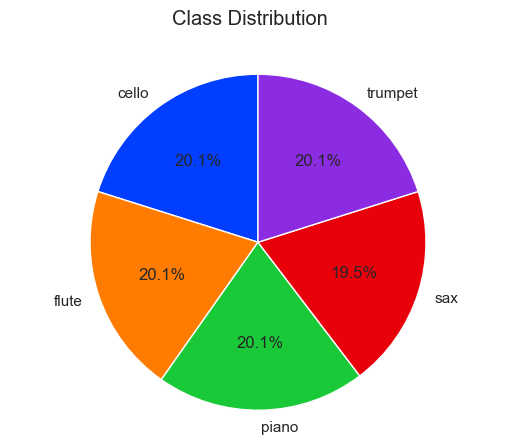

In [3]:
# %% Create annotations file if not already created for the dataset
# or load in the annotations csv file
if not os.path.exists(ANNOTATIONS):
    # Getting the dataframe for the file annotations
    annotations = dataset.create_file_annotations(AUDIO_FILES)
    # Save the dataframe to a CSV file
    annotations.to_csv(path_or_buf=ANNOTATIONS, sep=',', encoding='utf-8', index=False)
    print("Creating annotations .csv file")
else:
    annotations = pd.read_csv(ANNOTATIONS)

# Showing the head of the dataframe
print(annotations.head())

# Plotting the class distribution for the dataset
plotting.plot_class_distribution(annotations)

The annotations data can then be passed into a custom audio dataset object which loads an audio file, cleans it (applying a threshold envelope to remove any silence), resamples and reshapes to mono. A list of transforms have been created to later pass into the dataset to extract multiple features.

In [4]:
# %% Creating the dataset

# Creating a list of feature extractions / transformations that can later be applied to the audio
transforms = [feature_extraction.ExtractRMS(),
              feature_extraction.ExtractSpectralFlatness(SAMPLE_RATE, WIN_LENGTH),
              feature_extraction.ExtractSpectralCentroid(SAMPLE_RATE, WIN_LENGTH),
              feature_extraction.ExtractSpectralRolloff(SAMPLE_RATE, WIN_LENGTH),
              feature_extraction.ExtractZeroCrossingRate(),
              feature_extraction.ExtractMFCC(SAMPLE_RATE, NCEPS, NFILTS, WIN_LENGTH),
              feature_extraction.ExtractGFCC(SAMPLE_RATE, NCEPS, NFILTS, WIN_LENGTH)]

# Creating the dataset
# This dataset performs pre-processing on the audio files
# such as resampling, resizing (to mono), normalization, and feature extraction
# Here just the MFCC transform is passed to the dataset object
audio_dataset = dataset.AudioDataset(annotations, AUDIO_FILES, transforms[5], SAMPLE_RATE, NUM_SAMPLES)

## Feature Extraction

Feature extraction plays a crucial role in music information retrieval (MIR) tasks such as audio classification. Not only does it provide a layer of dimensionality reduction but it can also help to provide a model with the most relevant information to perform the given task.

Here we extract a few features for each class to visualise on a plot.

In [5]:
# %% Displaying each feature extraction for the first audio file in each class
# Creating temporary dictionaries to hold the data and the corresponding class label as a key
tmp_signals = {}
tmp_fft = {}
tmp_zcs = {}
tmp_fbank = {}
tmp_mfccs = {}
tmp_gfccs = {}
tmp_scs = {}
tmp_sfs = {}
tmp_srs = {}

# Getting all the unique class labels
classes = list(np.unique(annotations.ClassLabel))

# Iterating through the classes and selecting the first signal from each to extract features
for c in classes:
    wav_file = annotations[annotations.ClassLabel == c].iloc[0, 1]
    signal, fs = librosa.load(Path(AUDIO_FILES, wav_file), mono=True, sr=None)
    tmp_signals[c] = signal
    tmp_fft[c] = feature_extraction.calculate_fft(signal, fs)
    tmp_zcs[c] = feature_extraction.zero_crossing_rate(signal).T
    tmp_scs[c] = feature_extraction.spectral_centroid(y=signal, sr=fs).T
    tmp_srs[c] = feature_extraction.spectral_rolloff(y=signal+0.01, sr=fs).T
    tmp_sfs[c] = feature_extraction.spectral_flatness(y=signal).T
    tmp_fbank[c] = feature_extraction.logfbank(signal, fs, nfilt=NFILTS, nfft=WIN_LENGTH).T
    tmp_mfccs[c] = feature_extraction.mfcc(signal, fs, numcep=NCEPS, nfilt=NFILTS, nfft=WIN_LENGTH).T
    tmp_gfccs[c] = feature_extraction.gfcc(signal, fs, num_ceps=NCEPS, nfilts=NFILTS, nfft=WIN_LENGTH).T

One of the reasons why we do not use the original time based signal is due to the high-dimensional feature vectors it produces, especially for longer audio clips or high sampling rates; which ultimately increases the computational complexity and can lead to models not generalising. FFT's can also face the problem of lacking invariance and containing redundant or irrelevant information. 

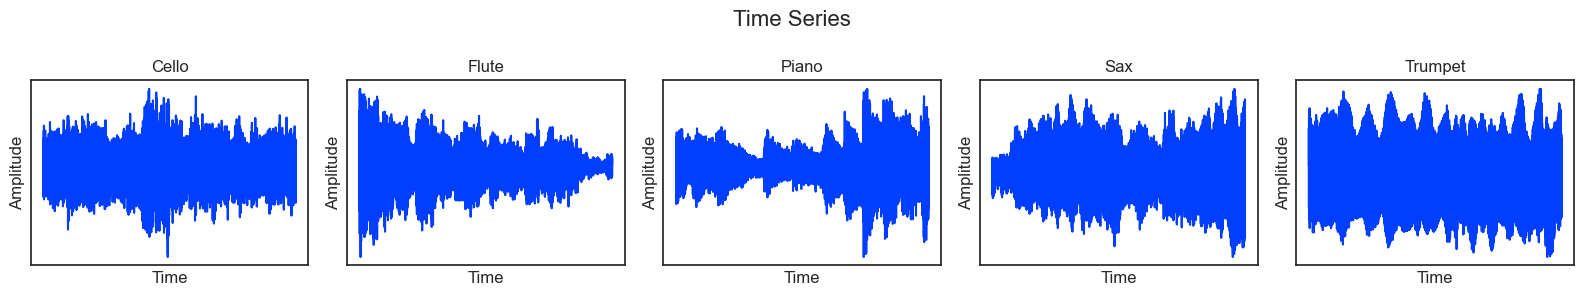

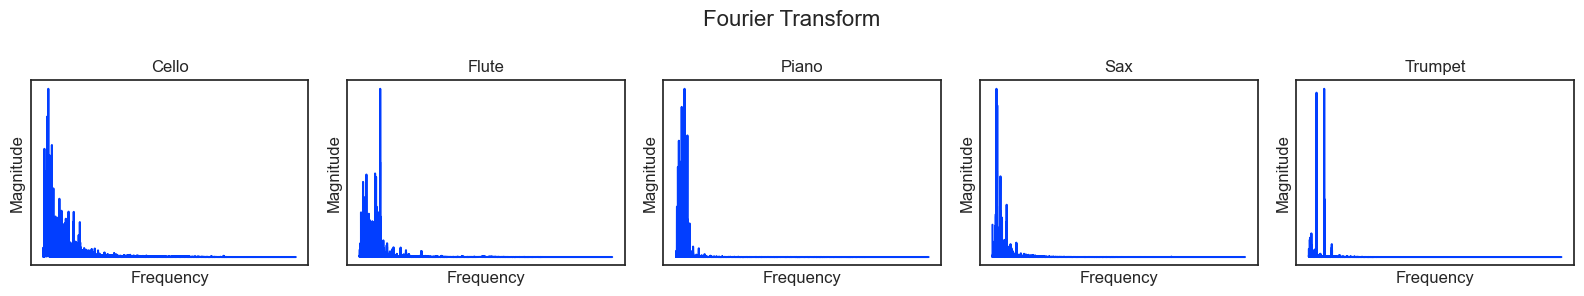

In [6]:
# Plotting the feature extractions of the audio
plotting.plot_signals_time(tmp_signals)
plotting.plot_ffts(tmp_fft)

Breebaart et al. (2004) compared various features such as mel-frequency cepstral coefficients (MFCC), auditory filter-bank temporal envelope (AFTE), standard low-level (SLL) and psychoacoustic (PA) features when training a standard Gaussian framework for both genre and general audio classification.

Some of the SLL features included Root-mean-square (RMS) level, spectral (centroid, bandwidth, and roll-off), zero-crossing rate, band energy ratio, delta spectrum magnitude, and pitch. The PA features included Roughness (the perception of temporal envelope modulations in the range of about 20-150 Hz), loudness (the sensation of signal strength) and sharpness (the spectral density and the relative strength of high-frequency energy) The AFTE features were made using GammaTone filter banks to create gammatone-frequency cepstral coefﬁcients (GFCC).

While the zero-crossing rate is good for percussive audio and capturing some temporal information, other features tend to perform better in most of the literature.

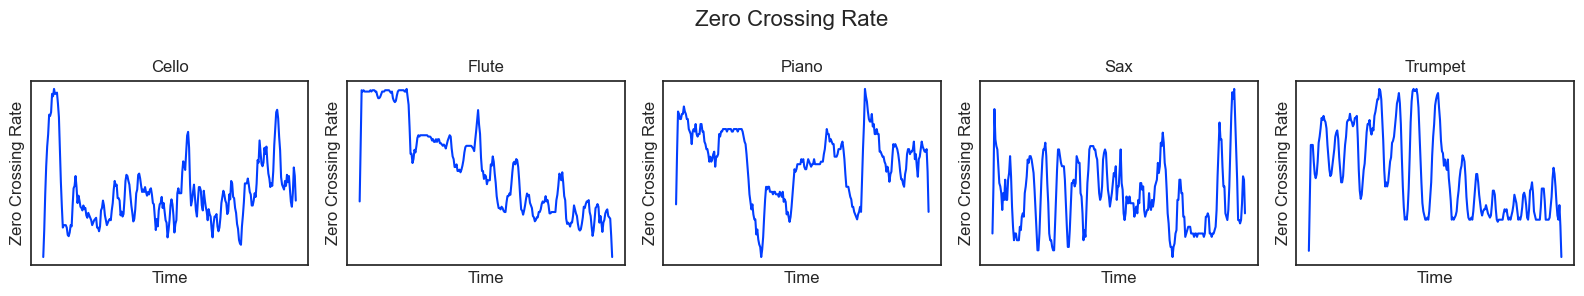

In [7]:
plotting.plot_time_feature(tmp_zcs, 'Zero Crossing Rate')

### Spectral Features

**Spectral Centroid** "indicates at which frequency the energy of a spectrum is centred upon" (Chauhan, 2020).

$$
\mathrm{SC}(m)=\frac{\sum_k f_k|X(m, k)|}{\sum_k|X(m, k)|}
$$

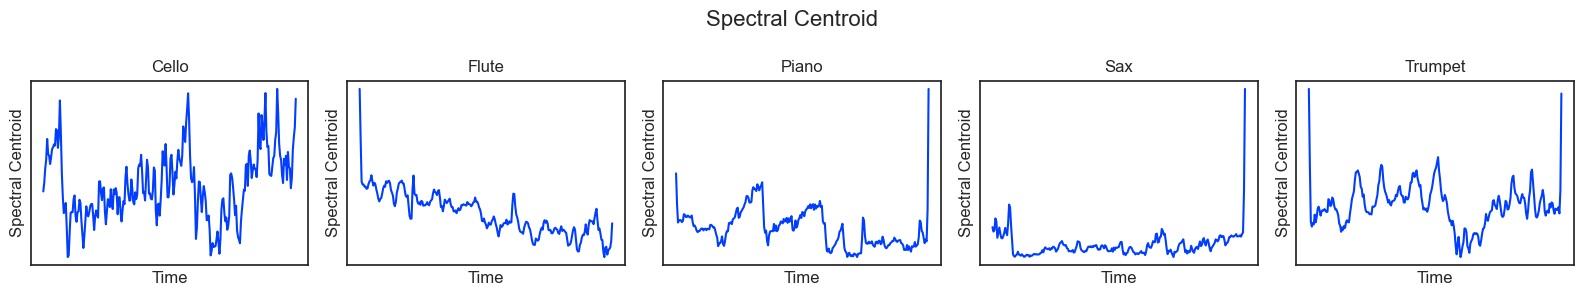

In [8]:
plotting.plot_time_feature(tmp_scs, 'Spectral Centroid')

**Spectral Flatness** measures the ratio of the geometric mean of the spectrum to the arithmetic mean of the spectrum (Johnston, 1988).

$$
\mathrm{SF}(m) = \frac{\left(\prod_k|X(m, k)|\right)^{\frac{1}{K}}}{\frac{1}{K} \sum_k|X(m, k)|}
$$

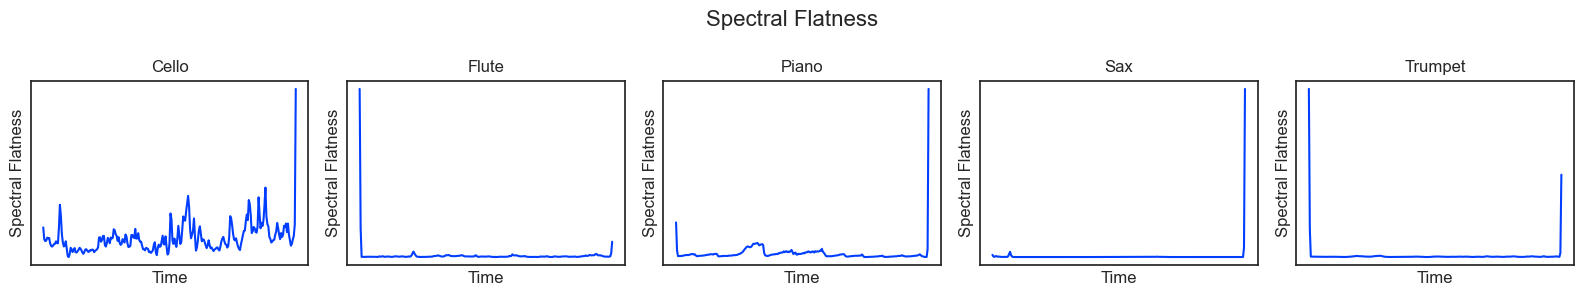

In [9]:
plotting.plot_time_feature(tmp_sfs, 'Spectral Flatness')

**Spectral Roll-off** is a metric that helps determine the bandwidth of an audio signal. It identifies the frequency bin below which a certain percentage of the total energy of the signal is concentrated (Scheirer and Slaney, 1997).

$$
\mathrm{SR}(m) = \frac{{\sum_k |X(m, k)|}}{{\sum_k |X(m, k)|}} \times \text{{roll\_off\_percentage}}
$$

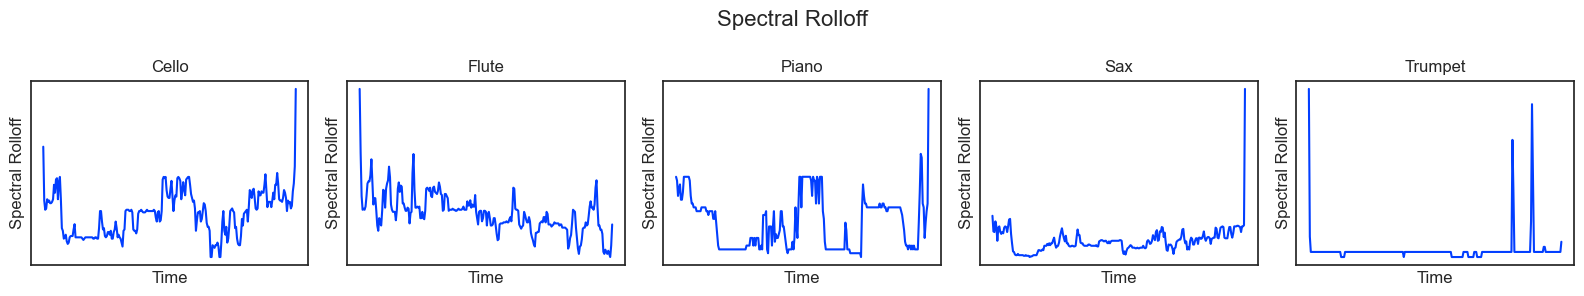

In [10]:
plotting.plot_time_feature(tmp_srs, 'Spectral Rolloff')

While filter banks are used in MIR as a feature extraction technique, MFCC's tend to be preferred over standard log filterbanks due to their perceptual relevance, better dimensionality reduction and robustness to noise.

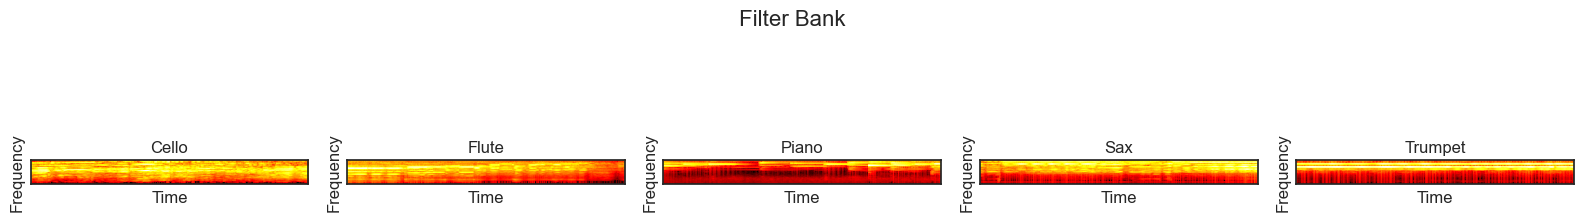

In [11]:
plotting.plot_spectrogram(tmp_fbank, 'Filter Bank')

### GFCC

It was demonstrated that AFTE features (like GFCC's) provided the highest accuracy in Breebaart's study, with MFCC's coming in at a close second. This corresponds with Liu's (2018) study showing 79% accuracy when training an attention based long short-term memory (LSTM+A) network with GFCC's.

**GFCC's** and GammaTone filter bands typically offer enhanced resolution in the lower frequency spectrum and generate a cochlegram, which is relative to the cochlea, an inner ear component.

This can be calculated using the following steps:
```flow
     Gammatone Filter bank
               ↓
Audio Input → FFT → Decimation → Non-Linear Rectification → DCT → GFCC Feature
```

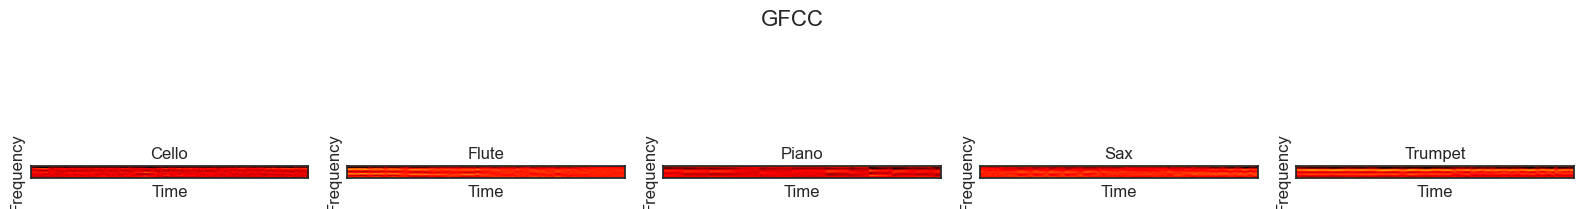

In [12]:
plotting.plot_spectrogram(tmp_gfccs, 'GFCC')


### MFCC

The literature above shows the results for general audio classification, whereas Deng et al. (2008) and Racharla et al. (2020) showed that MFCC and perception-based features dominated in support vector machines (SVM) for instrument classification models with up to 79% accuracy. Rathikarani (2020) also shows 98% accuracy with SVM and 95% with kNN classifiers using MFCC features in instrument classification.

**MFCC's** represent a non-linear 'spectrum-of-a-spectrum' where "the frequency bands are equally spaced on the mel scale, which approximates the human auditory system’s response" (Sdour, 2020). This is calculated similar to the GFCC but using mel filter banks.

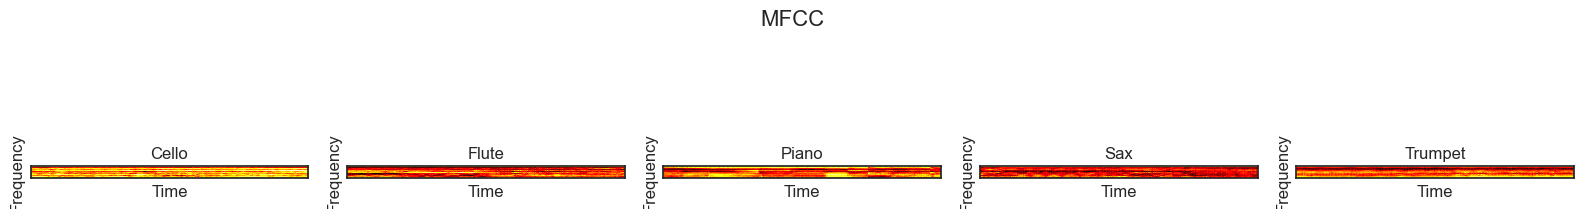

In [13]:
plotting.plot_spectrogram(tmp_mfccs, 'MFCC')

In [14]:
# Deleting the temporary dictionaries
del tmp_signals, tmp_fft, tmp_fbank, tmp_mfccs, tmp_gfccs, tmp_scs, tmp_sfs, tmp_srs

Dupont et al. (2013) used k-nearest neighbour (kNN) classification to compare dimensionality reduction techniques such as Isomap and t-SNE. He used the mean, standard deviation, skewness and kurtosis of the MFCC features.

The following transformations uses the **mean** and **standard deviation** for all features to further reduce the dimensions. Although, it was noted that some dimensionality reduction techniques such as LDA benefitted more from a flattened MFCC and GFCC.

Mean: $$\quad \bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i$$
Standard Deviation: $$\quad \sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}$$

In [15]:
# %% Extracting all features using the audio dataset object

# Create a pandas DataFrame to hold the features
columns = audio_dataset.get_multiple_transformations_columns(transforms)
features = []
targets = []

for i in range(len(audio_dataset)):
    data, target = audio_dataset.get_multiple_transformations(i, transforms)
    features.append(data)
    targets.append(target)

feature_dataset = pd.DataFrame(np.array(features), columns=columns)
feature_dataset['target'] = targets
targets = np.array(targets)
labels = audio_dataset.get_class_labels()

It's also important to perform **feature scaling** on the data as it can improve performance in gradient descent convergence when features are within similar ranges. Unscaled features can distort the distance metrics, leading to biased classifications or clustering results when using distance based algorithms such as support vector classification (SVC) or kNN's.

In [16]:
# Apply standardization to the features
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features)

## Feature Selection

There are two main feature selection techniques that can be used in this classification scenario, **Analysis of Variance (ANOVA)** and **Kendall's** algorithm. These methods will compare the variances between features and see how closely they correlate with the targets (Brownlee, 2020). ANOVA is used to select the top 10 features from this dataset. This is done by calculating the F-value for each feature, which measures the ratio of between-group variance to within-group variance. Here's the equation to compute the F-value for a single feature:

$$ F = \frac{{\text{Between-group variance}}}{{\text{Within-group variance}}} = \frac{{\text{MSB}}}{{\text{MSW}}} $$

- Between-group variance is the variance between different groups or classes.
- Within-group variance is the variance within each group or class.
- MSB is the Mean Square Between (or among) groups, calculated as the between-group sum of squares divided by the degrees of freedom between groups.
- MSW is the Mean Square Within groups, calculated as the within-group sum of squares divided by the degrees of freedom within groups.


In [17]:
# Feature selection
fvalue_Best = SelectKBest(f_classif, k=10)
features_best = fvalue_Best.fit_transform(features_scaled, targets)

## Dimensionality Reduction

### PCA

**Principal Component Analysis (PCA)** is a common method for reducing the features in a dataset while maintaining key information and patterns. This is performed by:
1. Normalising the continuous initial variables' range and calculate the mean vector
$$\quad \boldsymbol{\mu} = \frac{1}{N}\sum_{i=1}^{N} \mathbf{x}_i$$
2. Calculating the covariance matrix to detect correlations
$$\quad \mathbf{\Sigma} = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{x}_i - \boldsymbol{\mu}) (\mathbf{x}_i - \boldsymbol{\mu})^T$$
3. Computing the eigenvectors and eigenvalues of the covariance matrix to identify the main components
$$\quad \mathbf{\Sigma v}_i = \lambda_i \mathbf{v}_i \quad \text{for } i = 1, 2, ..., D$$
4. Formulate a feature vector to determine which principal components to retain
5. Transforming the data along the axes of principal components
$$\quad \mathbf{Y} = \mathbf{X} \mathbf{W}$$

The code below shows the cumulative explained variance along various dimensions of the PCA components. The red dashed line shows the best dimension.

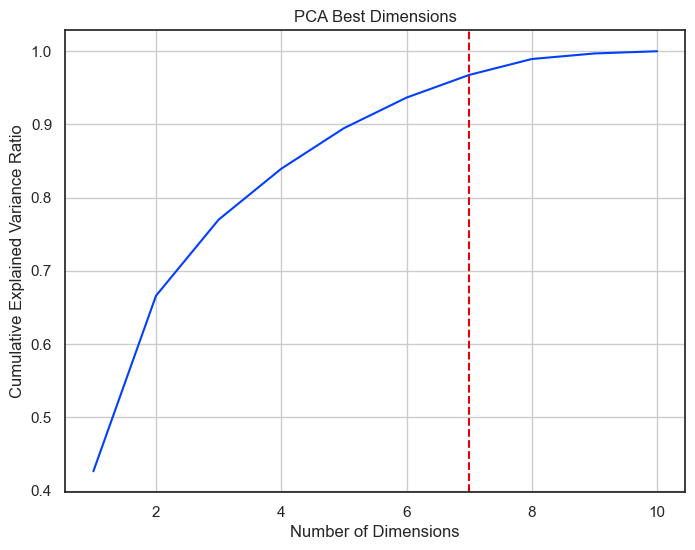

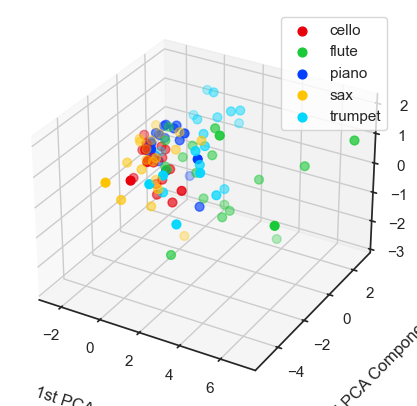

In [18]:
# Apply custom PCA
pca = dimentionality_reduction.PCA(-1)
features_pca = np.real(pca.fit_transform(features_best))

def get_best_dim(dr):
    # Getting the explained variance ratio
    explained_variance_ratio = dr.get_explained_variance()
    # Calculate the cumulative explained variance ratio
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
    # Find the number of dimensions with the highest explained variance
    best_dimensions = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1
    return explained_variance_ratio, cumulative_explained_variance_ratio, best_dimensions

# Calculate and plot the explained variance ratio for each principal component
pca_evr, pca_cevr, pca_bd = get_best_dim(pca)
plotting.plot_explained_variance(pca_evr, pca_cevr, pca_bd, 'PCA')

# Plotting PCA components (first 3 dimensions) on a 3D scatter plot
plotting.plot_dimentionality_reduction(features_pca, targets, labels, 'PCA')

### t-SNE

**t-distributed Stochastic Neighbor Embedding (t-SNE)** is a unsupervised method for dimensionality reduction on non-linear data, primarily used for preserving small pairwise distances unlike PCA. Van Der Maaten (2014) improves the Barnes-Hut implementation of the t-SNE which drastically accelerates the process using tree based algorithms as shown below. Pál et al. (2020) shows that t-SNE outperforms PCA, Isomap and Self-Organizing Maps (SOM) when using MFCC features for general audio dimensionality reduction (DR) in machine learning (ML).

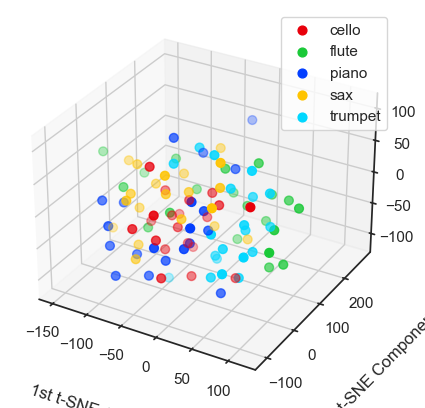

In [19]:
# Testing other dimensionality reduction techniques
features_tsne = TSNE(n_components=3, method='barnes_hut').fit_transform(features_best, targets)

plotting.plot_dimentionality_reduction(features_tsne, targets, labels, 't-SNE')

### LDA

As stated by Dupont et al. (2013), **Linear Discriminant Analysis (LDA)** is a common DR technique used in classification algorithms. This supervised DR method finds the linear combinations of features that best separate multiple classes while maximizing their between-class distance and minimizing their within-class variance. LDA is performed by:
1. Calculate the mean vectors for each class by averaging the feature vectors belonging to that class.
$$\quad \boldsymbol{\mu}_k = \frac{1}{N_k}\sum_{i=1}^{N_k} \mathbf{x}_{ki} \quad \text{for } k = 1, 2, ..., K$$
2. Determine the within-class scatter matrix by computing the scatter matrix for each class and summing them up.
$$\quad \mathbf{S}_W = \sum_{k=1}^{K} \sum_{i=1}^{N_k} (\mathbf{x}_{ki} - \boldsymbol{\mu}_k) (\mathbf{x}_{ki} - \boldsymbol{\mu}_k)^T$$
3. Derive the between-class scatter matrix by computing the mean vector of all data points across all classes and then calculating the scatter matrix between classes.
$$\quad \mathbf{S}_B = \sum_{k=1}^{K} N_k (\boldsymbol{\mu}_k - \boldsymbol{\mu}) (\boldsymbol{\mu}_k - \boldsymbol{\mu})^T$$
4. Find the eigenvectors and eigenvalues of the matrix formed by the product of the inverse of the within-class scatter matrix and the between-class scatter matrix.
$$\quad \mathbf{S}_W^{-1} \mathbf{S}_B \mathbf{w}_i = \lambda_i \mathbf{w}_i \quad \text{for } i = 1, 2, ..., D$$
5. Select the top k eigenvectors corresponding to the largest eigenvalues to form the projection matrix.
6. Project the original data onto the subspace formed by the selected eigenvectors to obtain the lower-dimensional representation of the data.

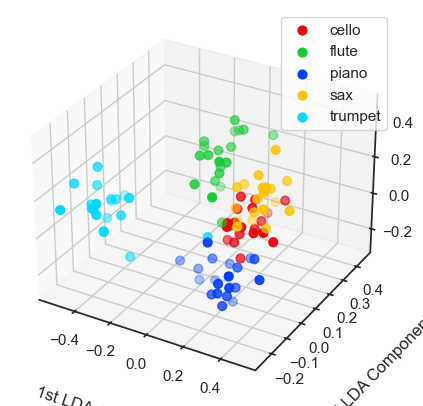

In [20]:
# Apply custom LDA
lda = dimentionality_reduction.LDA(-1)
features_lda = np.real(lda.fit_transform(features_scaled, targets))

plotting.plot_dimentionality_reduction(features_lda, targets, labels, 'LDA')

## Classification Models

As this dataset provides targets, supervised learning is most likely the best approach. As mentioned above, some common supervised learning models for audio classification are SVC's and kNN's.

### kNN

kNN is a versatile algorithm used for regression and classification tasks, relying on stored training data during prediction, making it a "lazy learning" method (IBM, 2024). It operates based on proximity, assigning labels or predicting values for new data points based on the majority label or average value of their k-nearest neighbors in the feature space. As kNN is classed as an instance-based / memory-based model, it can be computationally inefficient for large datasets and sensitive to the choice of distance metric and k value, particularly in high-dimensional spaces.

This was seen clearly during testing when using the flattened MFCC's / GFCC's the model's accuracy declined in comparison to using the mean and standard deviation of each cepstrum which increased the accuracy. The best K value can also be estimated by iterating over various training splits with different K values until the accuracy increases.

Various distance measures can be used for kNN's such as the Euclidean, Manhattan, Minkowski and Hamming distance.

**Euclidean Distance**
$$
d(x, y)=\sqrt{\sum_{i=1}^n\left(y_i-x_i\right)^2}
$$

**Manhattan Distance**
$$
\text { Manhattan Distance }=d(x, y)=\left(\sum_{i=1}^m\left|x_i-y_i\right|\right)
$$

**Minkowski Distance**
$$
\text { Minkowski Distance }=\left(\sum_{i=1}^n\left|x_i-y_i\right|\right)^{1 / p}
$$

**Hamming Distance**
$$
\begin{gathered}
\text { Hamming Distance }=D_H=\left(\sum_{i=1}^k\left|x_i-y_i\right|\right) \\
\begin{array}{rl}
x=y & D=0 \\
x \neq y & D \neq 1
\end{array}
\end{gathered}
$$

To perform kNN:
1. Calculate the distances between the sample and all examples in the training set using one of the distance measures shown above.
2. Select the k nearest neighbors based on the calculated distances.
3. Assign the class label to the test sample based on the majority class among its nearest neighbors.
$$\hat{y} = \text{argmax}_{c} \sum_{i=1}^{k} \delta(y_i, c)
$$

While the custom kNN implementation provides an option for various distance metrics, euclidean performed the best with minkowski coming at a close second.

### SVC

SVC's are part of the support vector machine (SVM) family. The model works by finding the hyperplane that best separates the classes in the feature space, with the goal of maximizing the margin between the classes (Kanade, 2022). SVM's can work well for both linear and non-linear data by using different kernel functions to map the input features into higher-dimensional spaces where separation is easier.

Although a custom SVM classification model was created in `models.SVC` it didn't produce the highest of accuracy compared to the sklearn SVC, as the custom model is quite simple in comparison. The custom model uses just a linear decision boundary for the kernel whereas, sklearn's SVC can use a gaussian radial basis function.

The three main kernels are:

|  | Linear | Polynomial | Gaussian (Radial Basis Fun) |
| :---: | :---: | :---: | :---: |
| $K\left(x, x^{\prime}\right)$ | $x^T x^{\prime}$ | $\phi(x)=\left(1+x^T x^{\prime}\right)^Q$ | $e^{-\gamma\left\\|x-x^{\prime}\right\\|^2}$ |

(Wisam, 2023)

To perform a simple SVC with a linear kernel:
1. Create the linear kernel which computes the dot product between feature vectors in the original feature space.
$$K(\mathbf{x}_n, \mathbf{x}_m) = \mathbf{x}_n^T \mathbf{x}_m
$$
2. Calculate the pairwise dot products between all pairs of data points to create the kernel matrix K. This then represents the similarity between data points in the original feature space.
3. Find the hyperplane's W and b by solving the dual optimization problem to find the optimal values of the lagrange multipliers.
$$\operatorname{Max}_\alpha \sum_{n=1}^N \alpha_n-\frac{1}{2}\left(\sum_{n=1}^N \sum_{m=1}^N y_n y_m \alpha_n \alpha_m K\left(x_n, x_m\right)\right) \text { such that } 0 \leq \alpha_n \leq C \text { and } \sum_{n=1}^N \alpha_n y_n=0
$$
4. Compute the support vectors and bias terms
5. Make predictions on the new data
$$f(\mathbf{x}) = \sum_{n=1} \alpha_n y_n K(\mathbf{x}_n, \mathbf{x}) + b
$$

### Random Forest

Random forest classification is a subgenre of ensemble learning methods. This model works by creating individual decision trees, each trained on a random subset of the data and making their own predictions. Then, all the predictions are combined together through a process called "voting" or "averaging", to make the final decision. Random forest is particularly effective because it introduces randomness into the model, leading to diverse trees that generalise well to unseen data. However, as seen below, random forest works best with larger datasets where it can capture more diverse patterns and relationships in the data.

The script below uses k-fold validation to provide an accuracy score for each model on each dimensionality reduction technique.

KNN with PCA
Mean Accuracy: 56.94%
Max Accuracy: 64.29%
Standard Deviation Accuracy: 7.30%

RF with PCA
Mean Accuracy: 56.94%
Max Accuracy: 66.67%
Standard Deviation Accuracy: 6.07%

SVC with PCA
Mean Accuracy: 69.12%
Max Accuracy: 78.57%
Standard Deviation Accuracy: 5.58%

KNN with LDA
Mean Accuracy: 44.15%
Max Accuracy: 57.14%
Standard Deviation Accuracy: 6.99%

RF with LDA
Mean Accuracy: 39.05%
Max Accuracy: 64.29%
Standard Deviation Accuracy: 12.06%

SVC with LDA
Mean Accuracy: 49.05%
Max Accuracy: 64.29%
Standard Deviation Accuracy: 10.82%



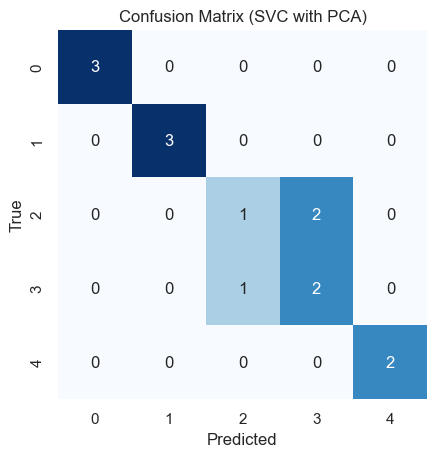

In [21]:
kf = StratifiedKFold(n_splits=K_FOLDS)

# Adding Dimensionality Reduction techniques and Classifiers
dimentionality_reductions = {
  'PCA': dimentionality_reduction.PCA(),
  'LDA': dimentionality_reduction.LDA()
}

classifiers = {
  'KNN': models.KNNClassifier(K_NEIGHBORS, distance_metric='euclidean'),
  'RF': RandomForestClassifier(n_estimators=40),
  'SVC': SVC(kernel='rbf', gamma='auto')
}

# Temporary dictionary to hold the scores for each model
scores = {}
for dr_name, dr in dimentionality_reductions.items():
  for classifier_name, classifier in classifiers.items():
    scores[f"{classifier_name} with {dr_name}"] = []

# A function used to train, predict and get the accuracy of the model
def get_score(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy, y_pred

fvalue_Best = SelectKBest(f_classif, k=10)
scaler = RobustScaler()

# Perform K-Fold cross validation on all models and dimensionality reduction techniques
for dr_name, dr in dimentionality_reductions.items():
  for train_index, test_index in kf.split(features, targets):

    # Splitting the k-fold data into training and testing sets
    X_train, X_test = features_best[train_index], features_best[test_index]
    y_train, y_test = targets[train_index], targets[test_index]

    # Perform standardisation
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # Performing feature selection
    X_train = fvalue_Best.fit_transform(X_train, y_train)
    X_test = fvalue_Best.fit_transform(X_test, y_test)

    # Apply the dimensionality reduction technique and convert from complex to real numbers
    X_train = np.real(dr.fit_transform(X_train, y_train))
    X_test = np.real(dr.transform(X_test))

    # Apply the classifier and get the accuracy
    for c_name, classifier in classifiers.items():
      accuracy, y_pred = get_score(classifier, X_train, X_test, y_train, y_test)
      scores[f"{c_name} with {dr_name}"].append({'accuracy': accuracy, 'y_preds': y_pred, 'y_tests': y_test})

# Getting the best and worst model for each classifier and dimensionality reduction technique
best_model = None
worst_model = None

for key, value in scores.items():
  mean_accuracy = np.mean([v['accuracy'] for v in value])
  if best_model is None or mean_accuracy > best_model_accuracy:
    best_model = key
    best_model_accuracy = mean_accuracy
  if worst_model is None or mean_accuracy < worst_model_accuracy:
    worst_model = key
    worst_model_accuracy = mean_accuracy

# Display the scores for each model and dimensionality reduction technique
for key, value in scores.items():
  if key == best_model:
    colour = PrintFormat.GREEN
  elif key == worst_model:
    colour = PrintFormat.RED
  else:
    colour = PrintFormat.YELLOW

  print(colour + PrintFormat.UNDERLINE + f"{key}" + PrintFormat.END)
  accuracies = [v['accuracy'] for v in value]
  print(PrintFormat.BOLD + f"Mean Accuracy: {np.mean(accuracies)*100:.2f}%" + PrintFormat.END)
  print(f"Max Accuracy: {np.max(accuracies)*100:.2f}%")
  print(f"Standard Deviation Accuracy: {np.std(accuracies)*100:.2f}%\n")

# Get the best test set from the best model to show confusion matrix
y_test = None
y_pred = None
best_accuracy = 0

for i in scores[best_model]:
  if i['accuracy'] > best_accuracy:
    best_accuracy = i['accuracy']
    y_test = i['y_tests']
    y_pred = i['y_preds']
        
# Display the confusion matrix as a heatmap
plotting.plot_confusion_matrix(y_test, y_pred, best_model)

### Convolutional Neural Networks

Convolutional Neural Networks (CNNs) are deep learning models specifically designed for processing data with higher dimensions. They consist of multiple layers of learnable filters that automatically extract hierarchical features from input data. CNNs improve upon traditional machine learning models like kNN, Random Forests, and SVMs by automatically learning feature representations from raw data, thereby eliminating the need for manual feature engineering. This enables CNNs to capture complex patterns and relationships in the data, making them more robust and accurate for tasks like audio classification.

Mahanta et al. (2023) CNN architecture was used as an example for the custom CNN developed below. The following CNN is a simplified version with a fully connected network containing 4 sequential layers. As seen in Mahanta's model, we use convolutional and Pooling layers with ReLU and Softmax activation functions.

Each sequential layer contains a series of convolutional layers, each followed by a ReLU activation function to introduce non-linearity. These layers learn to extract features from the input data. After each convolutional layer, there is a max-pooling layer, which reduces the spatial dimensions of the feature maps while retaining the most important information. This also helps to reduce computational complexity and over-fitting.

The output of the last convolutional layer is flattened into a one-dimensional tensor. This prepares the data for the fully connected layers. These fully connected layers perform classification based on the features extracted by the convolutional layers. The soft-max layer finally converts the raw scores from the previous layer into probabilities. Each output neuron represents the probability of the corresponding class.

In [22]:
cnn = models.CNNNetwork(audio_dataset.get_class_labels().size)
summary(cnn, (1, 64, 44))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 33, 23]          --
|    └─Conv2d: 2-1                       [-1, 16, 66, 46]          160
|    └─ReLU: 2-2                         [-1, 16, 66, 46]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 33, 23]          --
├─Sequential: 1-2                        [-1, 32, 17, 12]          --
|    └─Conv2d: 2-4                       [-1, 32, 35, 25]          4,640
|    └─ReLU: 2-5                         [-1, 32, 35, 25]          --
|    └─MaxPool2d: 2-6                    [-1, 32, 17, 12]          --
├─Sequential: 1-3                        [-1, 64, 9, 7]            --
|    └─Conv2d: 2-7                       [-1, 64, 19, 14]          18,496
|    └─ReLU: 2-8                         [-1, 64, 19, 14]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 9, 7]            --
├─Sequential: 1-4                        [-1, 128, 5, 4]           --
|    └─

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 33, 23]          --
|    └─Conv2d: 2-1                       [-1, 16, 66, 46]          160
|    └─ReLU: 2-2                         [-1, 16, 66, 46]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 33, 23]          --
├─Sequential: 1-2                        [-1, 32, 17, 12]          --
|    └─Conv2d: 2-4                       [-1, 32, 35, 25]          4,640
|    └─ReLU: 2-5                         [-1, 32, 35, 25]          --
|    └─MaxPool2d: 2-6                    [-1, 32, 17, 12]          --
├─Sequential: 1-3                        [-1, 64, 9, 7]            --
|    └─Conv2d: 2-7                       [-1, 64, 19, 14]          18,496
|    └─ReLU: 2-8                         [-1, 64, 19, 14]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 9, 7]            --
├─Sequential: 1-4                        [-1, 128, 5, 4]           --
|    └─

Since CNNs excel at processing high-dimensional features, and considering the success of MFCCs in previous experiments, this model utilises mel-spectrograms. Mel-spectrograms offer richer information compared to MFCCs (Doshi, 2021), and thanks to the CNN architecture's ability to handle complex data, they are well-suited for this task.

Below shows the training performed on the CNN:

In [23]:
def train(model, data_loader, loss_func, optimiser, epochs):
  '''
  Parameters -
    model: the model to train
    data_loader: the dataloader to optimise memory storage with batch downloads
    loss_func: the loss function to use to update the bias weightings
    optimiser: the optimiser to use for backwards propogation
    epochs: the number of epochs to run
  '''
  model.train()

  # Using a loading bar to show progress
  with tqdm(data_loader, unit="batch", total=len(data_loader)) as tepoch:

    # Increament through each epoch
    for epoch in range(epochs):
      for input, target in data_loader:
        tepoch.set_description(f"Epoch {epoch}")

        # Load the batch input into the device memory
        input, target = input, target

        # Calculate the loss
        output = model(input) # pass the inputs into the model
        loss = loss_func(output, target) # compare the predictions to the actual data

        # Calculate the accuracy of the model to display
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == target).sum().item()
        accuracy = correct / BATCH_SIZE

        # Backpropogate the loss and update the NN weights
        optimiser.zero_grad() # resets the gradients
        loss.backward() # performs back propogation
        optimiser.step() # updates the weights

        tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy)

  print("\nTraining Completed")

# Defining the loss function
loss_func = nn.CrossEntropyLoss()

# Defining the optimiser
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

transformation = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

audio_dataset = dataset.AudioDataset(annotations, AUDIO_FILES, transformation, SAMPLE_RATE, SAMPLE_RATE)
data_loader = DataLoader(audio_dataset, batch_size=BATCH_SIZE)

# Training the model
validation_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(audio_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(audio_dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(audio_dataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler)

# Train the network
train(cnn, train_loader, loss_func, optimiser, EPOCHS)

# Saving the model state
model_state_path = "cnn.pth"
torch.save(cnn.state_dict(), model_state_path)
print(f"Model trained and stored  at '{model_state_path}'")

Epoch 59:   0%|          | 0/1 [01:33<?, ?batch/s, accuracy=49.2, loss=1.27]


Training Completed
Model trained and stored  at 'cnn.pth'


When using the full dataset, the model's accuracy outperformed all of the above. However, when splitting the data for testing / validation, the accuracy decreases drastically as neural networks tend to perform better with larger datasets.

Accuracy: 60.00%


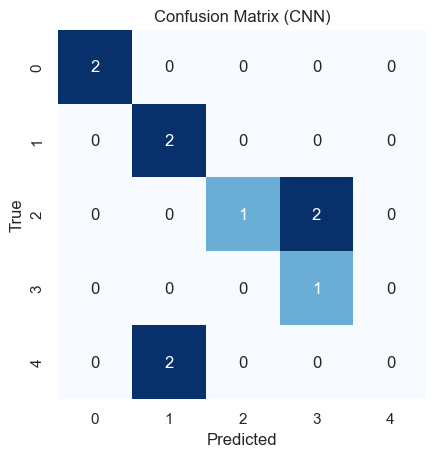

In [26]:
# Load the CNN model state
cnn.load_state_dict(torch.load(model_state_path))
cnn.eval()

# Generate predictions for the validation set
all_preds = []
all_targets = []
with torch.no_grad():
    for input, target in validation_loader:
        output = cnn(input)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_targets.extend(target.tolist())

# Print the accuracy of the model
accuracy = accuracy_score(all_targets, all_preds)
print(f"Accuracy: {accuracy*100:.2f}%")

# Calculate the confusion matrix
plotting.plot_confusion_matrix(all_targets, all_preds, 'CNN')

## Bibliography

Breebaart, J. and McKinney, M. (01 2004) ‘Features for Audio Classification’, in. doi: 10.1007/978-94-017-0703-9.


Brownlee, J. (2020) How to Choose a Feature Selection Method For Machine Learning. Available at: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/.


Chauhan, N. S. (2020) Audio Data Analysis Using Deep Learning with Python. Available at: https://www.theaidream.com/post/audio-data-analysis-using-deep-learning-with-python-part-1.


Deng, J. D., Simmermacher, C. and Cranefield, S. (2008) ‘A Study on Feature Analysis for Musical Instrument Classification’, IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), 38, pp. 429–438. Available at: https://api.semanticscholar.org/CorpusID:1408712.


Doshi, K. (2021) Audio Deep Learning Made Simple - Why Mel Spectrograms perform better. Available at: https://ketanhdoshi.github.io/Audio-Mel/.


Dupont, S. et al. (2013) ‘Nonlinear dimensionality reduction approaches applied to music and textural sounds’, in 2013 IEEE International Conference on Multimedia and Expo (ICME), pp. 1–6. doi: 10.1109/ICME.2013.6607550.


IBM (2024) What is the k-nearest neighbors algorithm? Available at: https://www.ibm.com/topics/knn.


Johnston, J. D. (1988) ‘Transform coding of audio signals using perceptual noise criteria’, IEEE Journal on Selected Areas in Communications, 6(2), pp. 314–323. doi: 10.1109/49.608.


Kanade, V. (2022) All You Need to Know About Support Vector Machines. Available at: https://www.spiceworks.com/tech/big-data/articles/what-is-support-vector-machine/.


Liu, G. K. (2018) ‘Evaluating Gammatone Frequency Cepstral Coefficients with Neural Networks for Emotion Recognition from Speech’, CoRR, abs/1806.09010. Available at: http://arxiv.org/abs/1806.09010.


Mahanta, S. K. et al. (2023) ‘Exploiting cepstral coefficients and CNN for efficient musical instrument classification’, Evolving Systems. Springer, pp. 1–13.


Pál, T. and Várkonyi, D. (09 2020) ‘Comparison of Dimensionality Reduction Techniques on Audio Signals’.


Racharla, K. et al. (2020) ‘Predominant Musical Instrument Classification based on Spectral Features’, in 2020 7th International Conference on Signal Processing and Integrated Networks (SPIN). IEEE. doi: 10.1109/spin48934.2020.9071125.


Rathikarani, V., Dhanalakshmi, P. and S., P. (05 2020) ‘Classification of Musical Instruments using SVM and KNN’, International Journal of Innovative Technology and Exploring Engineering, 9, pp. 2278–3075. doi: 10.35940/ijitee.G5836.059720.


Scheirer, E. D. and Slaney, M. (1997) ‘Construction and evaluation of a robust multifeature speech/music discriminator’, 1997 IEEE International Conference on Acoustics, Speech, and Signal Processing, 2, pp. 1331–1334 vol.2. Available at: https://api.semanticscholar.org/CorpusID:12331395.


Sdour, A. (2021) From «MFCCs xor GFCCs» to «MFCCs and GFCCs» : Urban Sounds Classification case study | Towards Data Science. Available at: https://towardsdatascience.com/from-mfccs-xor-gfccs-to-mfccs-and-gfccs-urban-sounds-classification-case-study-a087ac007901.


Van Der Maaten, L. (2014) ‘Accelerating t-SNE using tree-based algorithms’, J. Mach. Learn. Res. JMLR.org, 15(1), pp. 3221–3245.


Wisam, E. (2023) Easily Implement Multiclass SVM From Scratch in Python. Available at: https://towardsdatascience.com/implement-multiclass-svm-from-scratch-in-python-b141e43dc084.


Zaman, K. et al. (2023) ‘A Survey of Audio Classification Using Deep Learning’, IEEE Access, 11, pp. 106620–106649. doi: 10.1109/ACCESS.2023.3318015.